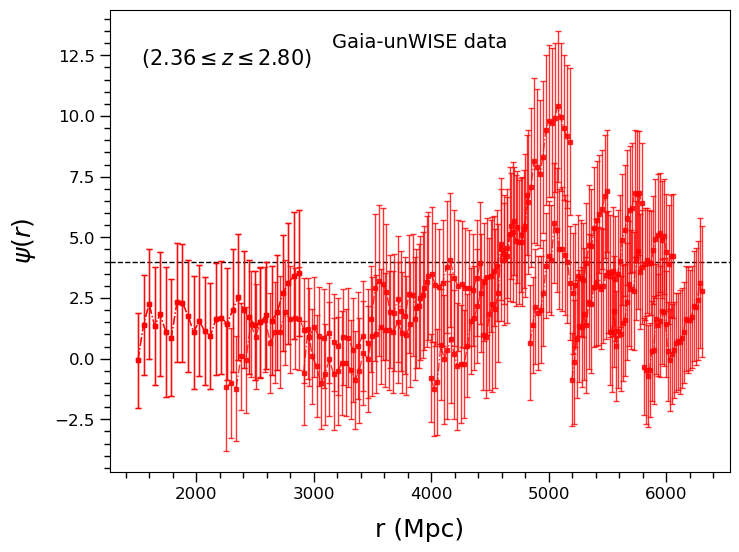

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from joblib import Parallel, delayed
from tqdm import tqdm
import os

# Create directory for intermediate output
file_inter = "inter_data1"
os.makedirs(file_inter, exist_ok=True)

# Parameters
nside = 8  # Healpix resolution
nf = 100   # Number of bootstrap samples
nbin = 30  # Number of radial bins
use_cores = 15
# Compute Rényi entropy for a given dataset
def compute_renyi_entropy(input_file, output_file, rmin, rmax, Nside=nside, nbin=30):
    Npix = hp.nside2npix(Nside)
    
    # Load input data
    df = pd.read_csv(input_file, sep="\t", header=None)
    df.columns = ['r', 'th', 'ph']
    r1 = df['r'].to_numpy()
    th1 = df['th'].to_numpy()
    ph1 = df['ph'].to_numpy()

    dr = (rmax - rmin) / nbin
    m = np.zeros((nbin, Npix), dtype=float)
    Neff = np.zeros(nbin, dtype=int)

    # Fill Healpix map
    for rr, tt, pp in zip(r1, th1, ph1):
        for j in range(nbin):
            if rmin <= rr <= (rmin + (j+1) * dr):
                px = hp.ang2pix(Nside, tt, pp)
                m[j][px] += 1
                Neff[j] += 1

    # Normalize to probability
    p = np.zeros((nbin, Npix), dtype=float)
    for i in range(nbin):
        if Neff[i] > 0:
            p[i] = m[i] / Neff[i]

    # Compute Rényi entropies for q=1 to 5
    H = np.zeros((nbin, 5), dtype=float)
    for k in range(5):
        q = k + 1
        for i in range(nbin):
            if q == 1:
                H[i][k] = -np.sum(p[i][p[i] > 0] * np.log10(p[i][p[i] > 0]))
            else:
                h_q = np.sum(p[i] ** q)
                if h_q > 0:
                    H[i][k] = np.log10(h_q) / (1 - q)

    # Radius bins
    R = rmin + (np.arange(1, nbin + 1) * dr)
    
    # Save output
    df_out = pd.concat([pd.DataFrame(R), pd.DataFrame(H)], axis=1)
    df_out.to_csv(output_file, sep='\t', header=False, index=False)

# Helper function for parallel processing
def process_sample(n, l, df_base, R_min, R_max, file_inter):
    fd = df_base.sample(frac=0.8, replace=True, random_state=l)
    f_samp = f"{file_inter}/sample{n+1}_{l+1}.dat"
    f_out2 = f"{file_inter}/anis_s{n+1}_{l+1}.dat"
    fd.to_csv(f_samp, sep="\t", header=None, index=False)
    compute_renyi_entropy(f_samp, f_out2, R_min[n], R_max[n])

# Main loop for each input dataset (10 samples)
R_max = np.zeros(10)
R_min = np.zeros(10)

for n in range(10):
    # Input file
    f_in = f'../data_needed/all_samples/sample_{n+1}.dat'
    df = pd.read_csv(f_in, sep="\t", header=None)
    df.columns = ['r', 'th', 'ph']
    
    # Compute global r min/max
    R_max[n] = df['r'].max()
    R_min[n] = df['r'].min()

    # Full-sample entropy
    f_out1 = f"{file_inter}/renyi_anis_s{n+1}.dat"
    compute_renyi_entropy(f_in, f_out1, R_min[n], R_max[n])

    # Bootstrap samples (parallelized)
    Parallel(n_jobs=use_cores, backend='loky')(
        delayed(process_sample)(n, l, df, R_min, R_max, file_inter)
        for l in range(nf))
##############################################################################################

from statistics import mean, stdev
#calculation of normalized entropy dispersion and error associated with it (very simple way manually)
nbin = 30
for n in range(10):
    file = 'inter_data1/renyi_anis_s'+ str(n+1)+'.dat'
    RR = np.loadtxt(file)[:,0]
    s1 = np.loadtxt(file)[:,1]
    s2 = np.loadtxt(file)[:,2]
    s3 = np.loadtxt(file)[:,3]
    s4 = np.loadtxt(file)[:,4]
    s5 = np.loadtxt(file)[:,5]

    stab_cri = np.zeros(len(RR))
    s_mean = np.zeros(len(RR))
    for i in range(len(RR)):
        s_mean[i] = (s1[i]+s2[i]+s3[i]+s4[i]+s5[i])/5.0
        stab_cri[i] = np.sqrt((1/5)*((s1[i]-s_mean[i])**2+(s2[i]-s_mean[i])**2+(s3[i]-s_mean[i])**2
                                    +(s4[i]-s_mean[i])**2+(s5[i]-s_mean[i])**2))
    frac_cri = stab_cri/s_mean
    dict1 = {'r': RR, 'crit':frac_cri} 
    fd = pd.DataFrame(dict1)
    file_out = 'inter_data1/sample'+ str(n+1)+'_crit.csv'
    fd.to_csv(file_out,index=False)
######################################################################################################

for n in range(10): 
    file_cri = 'inter_data1/sample'+ str(n+1)+'_crit.csv'
    df_cri = pd.read_csv(file_cri)
    crit_samp = df_cri['crit'].to_numpy()
    
    criteria = np.zeros((nf,nbin)) 
    d_crit = np.zeros(nbin) 
    for f in range(nf):
        file = 'inter_data1/anis_s'+ str(n+1) + '_' + str (f+1) + '.dat'       
        RR = np.loadtxt(file)[:,0]
        a1 = np.loadtxt(file)[:,1]
        a2 = np.loadtxt(file)[:,2]
        a3 = np.loadtxt(file)[:,3]
        a4 = np.loadtxt(file)[:,4]
        a5 = np.loadtxt(file)[:,5]
        a_mean = np.zeros(len(RR))
        stab_cri = np.zeros(len(RR))
        for i in range(len(RR)):
            a_mean[i] = (a1[i]+a2[i]+a3[i]+a4[i]+a5[i])/5.0
            stab_cri[i] = np.sqrt((1/5)*((a1[i]-a_mean[i])**2+(a2[i]-a_mean[i])**2+(a3[i]-a_mean[i])**2
                                    +(a4[i]-a_mean[i])**2+(a5[i]-a_mean[i])**2))
    
        criteria[f] = stab_cri/a_mean
    for i in range(nbin):
        list_crit = []
        for j in range(nf):
            list_crit.append(criteria[j][i])
            
         
       # mean_crit[i] = mean(list_crit)        
        d_crit[i] = stdev(list_crit)
        
    dict1 = {'r': RR, 'crit':crit_samp, 'sd': d_crit } 
    fd_out = pd.DataFrame(dict1)
    f_name1 = 'inter_data1/sample_'+str(n+1)+'_criteria_err.csv' 
    fd_out.to_csv(f_name1,index=False)
#######################################################################################################
import os
for n in range(10):
    f_out1 = 'inter_data1/renyi_anis_s'+ str(n+1)+'.dat'
    os.remove(f_out1)
    f_out2 = 'inter_data1/sample'+ str(n+1)+'_crit.csv'
    os.remove(f_out2)
    for l in range(nf):
        file_name = 'inter_data1/anis_s'+ str(n+1) + '_' + str (l+1) + '.dat'
        os.remove(file_name)
        f_samp = 'inter_data1/sample'+ str(n+1) + '_' + str(l+1) + '.dat' 
        os.remove(f_samp)
##############################################################################################3


